<a href="https://colab.research.google.com/github/jonas-eschle/applied_stats_physics/blob/main/Applied_stats_module3_syr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disclaimer

Depending on conventions etc., some things here are maybe wrong and not according to the lecture. Do not use it for your solution but as an illustrative example on how to tackle the problem.

In [1]:
!pip install -q -U zfit[all] scipy mplhep iminuit

# $\chi^2$ and goodness of fit

Remember
- **p-value**: probability to accept H1 (alternative) although H0 is true -> probability to say that the fit is bad (i.e. H1, something we did not fit) although it's actually good (the function fits well)
- we need distribution of H0! -> $\chi^2$ is a NLL (negative log-likelihood) of multiple Gaussian distributions $G(y_i;  \mu =f(x_i), \sigma = \sigma_i $ -> H0 is that $y_i$ is distributed around $f(x_i)$ with width $\sigma_i$.

(forward reference for HEP statistics, fits: pull studies with toys)



In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import mplhep

mplhep.style.use(mplhep.style.LHCb2)

In [3]:
data = np.array([[ 30.        , 479.        ,  21.88606863],
       [ 45.        , 380.        ,  19.49358869],
       [ 60.        , 302.        ,  17.3781472 ],
       [ 75.        , 185.        ,  13.60147051],
       [ 90.        , 157.        ,  12.52996409],
       [105.        , 137.        ,  11.70469991],
       [120.        , 119.        ,  10.90871211],
       [135.        , 119.        ,  10.90871211],
       [150.        ,  89.        ,   9.43398113],
       [165.        ,  74.        ,   8.60232527],
       [180.        ,  61.        ,   7.81024968],
       [195.        ,  66.        ,   8.1240384 ],
       [210.        ,  68.        ,   8.24621125],
       [225.        ,  48.        ,   6.92820323],
       [240.        ,  54.        ,   7.34846923],
       [255.        ,  51.        ,   7.14142843],
       [270.        ,  46.        ,   6.78232998],
       [285.        ,  55.        ,   7.41619849],
       [300.        ,  29.        ,   5.38516481],
       [315.        ,  28.        ,   5.29150262],
       [330.        ,  37.        ,   6.08276253],
       [345.        ,  49.        ,   7.        ],
       [360.        ,  26.        ,   5.09901951],
       [375.        ,  35.        ,   5.91607978],
       [390.        ,  29.        ,   5.38516481],
       [405.        ,  31.        ,   5.56776436],
       [420.        ,  24.        ,   4.89897949],
       [435.        ,  25.        ,   5.        ],
       [450.        ,  35.        ,   5.91607978],
       [465.        ,  24.        ,   4.89897949],
       [480.        ,  30.        ,   5.47722558],
       [495.        ,  26.        ,   5.09901951],
       [510.        ,  28.        ,   5.29150262],
       [525.        ,  21.        ,   4.58257569],
       [540.        ,  18.        ,   4.24264069],
       [555.        ,  20.        ,   4.47213595],
       [570.        ,  27.        ,   5.19615242],
       [585.        ,  17.        ,   4.12310563],
       [600.        ,  17.        ,   4.12310563],
       [615.        ,  14.        ,   3.74165739],
       [630.        ,  17.        ,   4.12310563],
       [645.        ,  24.        ,   4.89897949],
       [660.        ,  11.        ,   3.31662479],
       [675.        ,  22.        ,   4.69041576],
       [690.        ,  17.        ,   4.12310563],
       [705.        ,  12.        ,   3.46410162],
       [720.        ,  10.        ,   3.16227766],
       [735.        ,  13.        ,   3.60555128],
       [750.        ,  16.        ,   4.        ],
       [765.        ,   9.        ,   3.        ],
       [780.        ,   9.        ,   3.        ],
       [795.        ,  14.        ,   3.74165739],
       [810.        ,  21.        ,   4.58257569],
       [825.        ,  17.        ,   4.12310563],
       [840.        ,  13.        ,   3.60555128],
       [855.        ,  12.        ,   3.46410162],
       [870.        ,  18.        ,   4.24264069],
       [885.        ,  10.        ,   3.16227766]])


x = data[:, 0]
y = data[:, 1]
sigma = data[:, 2]

In [4]:
# define models

def linear(x, a, m):
    value = a + m * x
    return value
    # return np.maximum(value, 1e-100)  # can be used to prevent from going negative

def exponential(x, scale, lam):
    return scale * np.exp(-x * lam)


def func(x, params):
    return exponential(x, params[0], params[1]) + exponential(x, params[2], params[3]) + linear(x, params[4], params[5])

## Normalization

Note that these are functions, not PDFs. But in the Likelihood, we need PDFs?

Yes, but remember: the functions here are the $\mu$ in our Gaussians that we fit, *not* the PDF that we fit.
(i.e. that's what the $\chi^2$ is doing)

In [5]:
# define loss/cost

def chi2(params):  # is a function of params, it's an NLL!
    pred = func(x, params)
    chi = (y - pred) / sigma
    return np.sum(chi ** 2)

## Next step: optimization

Problem: local optimizers need good starting values.

Hint: why not plot first?

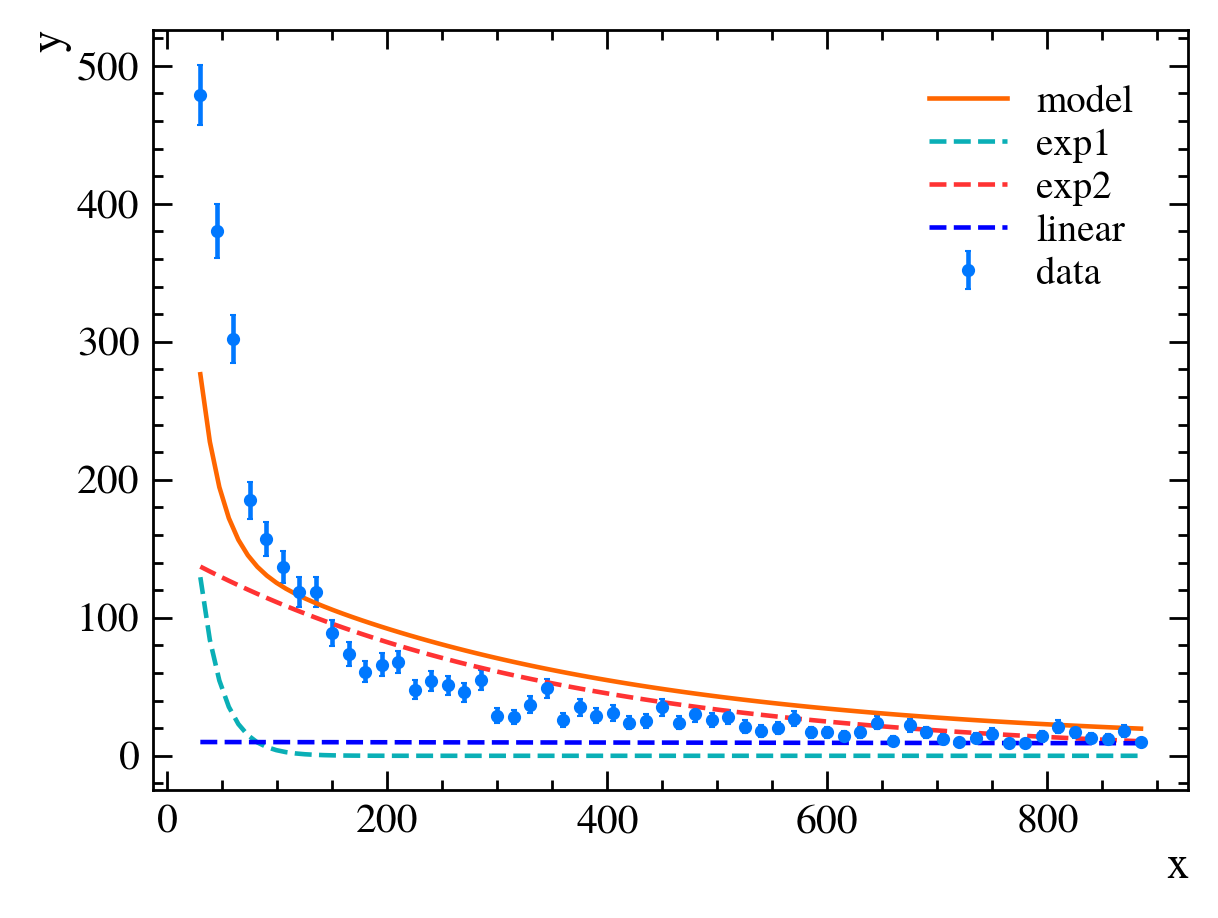

In [6]:
# param_init = [100, 0.05, 100, 0.03, 100, 1]
param_init = [580, 0.05, 150, 0.003, 10, -0.001]

def plotmodel(params):
    xplot = np.linspace(np.min(x), np.max(x), 100)
    plt.figure()
    plt.errorbar(x, y, yerr=sigma, fmt='.', label="data")
    plt.plot(xplot, func(xplot, params), label="model")

    plt.plot(xplot, exponential(xplot, params[0], params[1]), '--', label="exp1")
    plt.plot(xplot, exponential(xplot, params[2], params[3]), '--', label="exp2")
    plt.plot(xplot, linear(xplot, params[4], params[5]), '--', label="linear")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

plotmodel(param_init)

In [7]:
# let's minimize that

opt = sp.optimize.minimize(chi2, param_init)

In [8]:
opt  # says False in success? What's the criterion to stop?

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 64.59613798916568
        x: [ 8.155e+02  2.372e-02  1.572e+02  1.988e-03 -6.299e+01
             5.468e-02]
      nit: 157
      jac: [ 1.049e-05 -1.578e+00  5.733e-03 -5.196e+02  2.011e-02
             1.314e+01]
 hess_inv: [[ 2.071e+03  5.195e-02 ...  2.684e+02 -1.476e-01]
            [ 5.195e-02  2.185e-06 ...  6.347e-02 -3.822e-05]
            ...
            [ 2.684e+02  6.347e-02 ...  9.558e+03 -6.038e+00]
            [-1.476e-01 -3.822e-05 ... -6.038e+00  3.824e-03]]
     nfev: 1621
     njev: 230

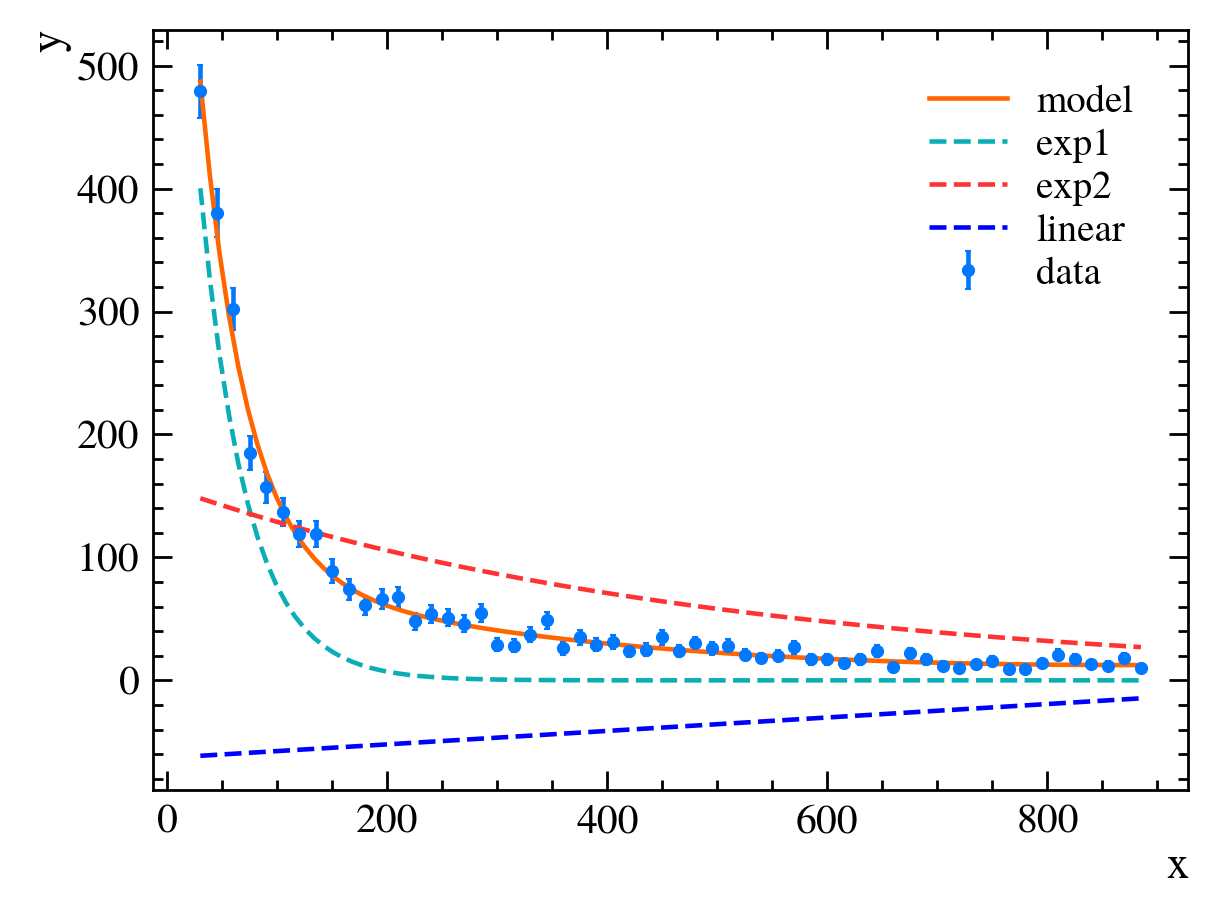

In [9]:
plotmodel(opt.x)

## What to do now?

Tweak around. Remember that we are interested in max(likelihood) (or min(NLL) = min(chi2)) and we're just trying to find good starting values that our _local_ minimizer finds the actual max/min. So we can do whatever, as long as we're sure to have found in the end the actual min/max

Different strategies:
- give initial step size (approximate uncertainy of parameter). Compare: a yield which is order of $10^5-10^6$ vs an exponential λ that is $10^-2-10^3$ (initial hessian)
- play with the plot
- minimize _partially_, i.e., subset of parameteres on _subset of range_ (forward reference: mass fit side bands). For example, just fit the steep gaussian on the left and leave the other parameters fixed.
- global minimizer: expensive, but doable (scipy has some).
- "constraints": make sure that the parameter stays within boundaries. Constraints are "always bad", because they add more terms to the likelihood, they change the landscape. Therefore, we need to be sure that _once we're at the min_, they don't influence us anymore -> good idea to rerun after a minimum was found _without_ constraints but good starting values (i.e. _close_ (not exact) to the minimum) -> sometimes, a "necessary evil" (a bit like guard rails on the street: it's good to have them but we should not rely on them, at least not in the "final fit")
- additional knowledge: can we measure one of these somewhere else? Do we have simulation to fix parts of the shape?

In [10]:
import zfit

obs = zfit.Space("x", (np.min(x), np.max(x)))

lamb1 = zfit.Parameter("lambda1", 0.05, 0.0001, 0.1)
lamb2 = zfit.Parameter("lambda2", 0.02, 0.0001, 0.1)
mlinear = zfit.Parameter("m", -0.01,-5, 5)

scale_exp1 = zfit.Parameter("yield_exp1", 300, step_size=1)
scale_exp2 = zfit.Parameter("yield_exp2", 300, step_size=1)
scale_bkg = zfit.Parameter("yield_bkg", 100, 0, 500, step_size=1)  # limits _can_ help, but they should, ideally, be far away

exp1 = zfit.pdf.Exponential(lamb1, obs=obs, extended=scale_exp1)
exp2 = zfit.pdf.Exponential(lamb2, obs=obs, extended=scale_exp2)
bkg = zfit.pdf.Chebyshev(obs=obs, coeffs=mlinear, extended=scale_bkg)

model = zfit.pdf.SumPDF([exp1, exp2, bkg])

# here, converting it to the actual histogram can easily be done using "hist" (histogram library, standard in Python HEP)
# h = ...
# convert model to binnd with model.to_binned(binning)
# nll = zfit.loss.ExtendedBinnedChi2(model=model, data=h)


/usr/local/lib/python3.10/dist-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


There are many different minimizers out there, zfit wraps [many of them (see docs)](https://zfit.readthedocs.io/en/latest/user_api/minimize/minimizers.html)

Feel free to test the original ones

iminuit just works the best overall...

In [11]:
# different minimizers, see also
minimizer = zfit.minimize.Minuit(verbosity=7)
# minimizer = zfit.minimize.ScipyTrustConstrV1(verbosity=6)
# minimizer = zfit.minimize.NLoptISRESV1(verbosity=6)
# minimizer = zfit.minimize.IpyoptV1(verbosity=6)

In [12]:
# result = minimizer.minimize(nll)
# result.hesse()
# print(result)

In [13]:
zfit.run.set_graph_mode(False)
zfit.run.set_autograd_mode(False)

chi2.errordef = 1  # to indicate how much change in the loss function means "1 sigma difference" (i.e. for likelihood, this would be 0.5)

In [14]:
res = minimizer.minimize(chi2, params=param_init)
print(res)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       1074.403287 Edm =       1922.265126 NCalls =     23
I NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
I MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 900.9863523
  Edm           : 2142.918839
  Internal parameters:	[              580    0.03042667308              150            0.003               10           -0.001]	
  Internal gradient  :	[    -0.3263835345      5313.050907      18.06293568     -1195346.467      78.48090666      42579.13319]	
  Internal covariance matrix:
[[      1432.7391              0              0              0              0              0]
 [              0  1.4185932e-06              0              0              0              0]
 [              0              0      6.8754828              0              0              0]
 [              0              0              0   1.264507e-0

In [15]:
np.array(res.params)

array([ 8.16926575e+02,  2.40225717e-02,  1.32101501e+02,  2.46904884e-03,
       -3.34154205e+01,  3.48733477e-02])

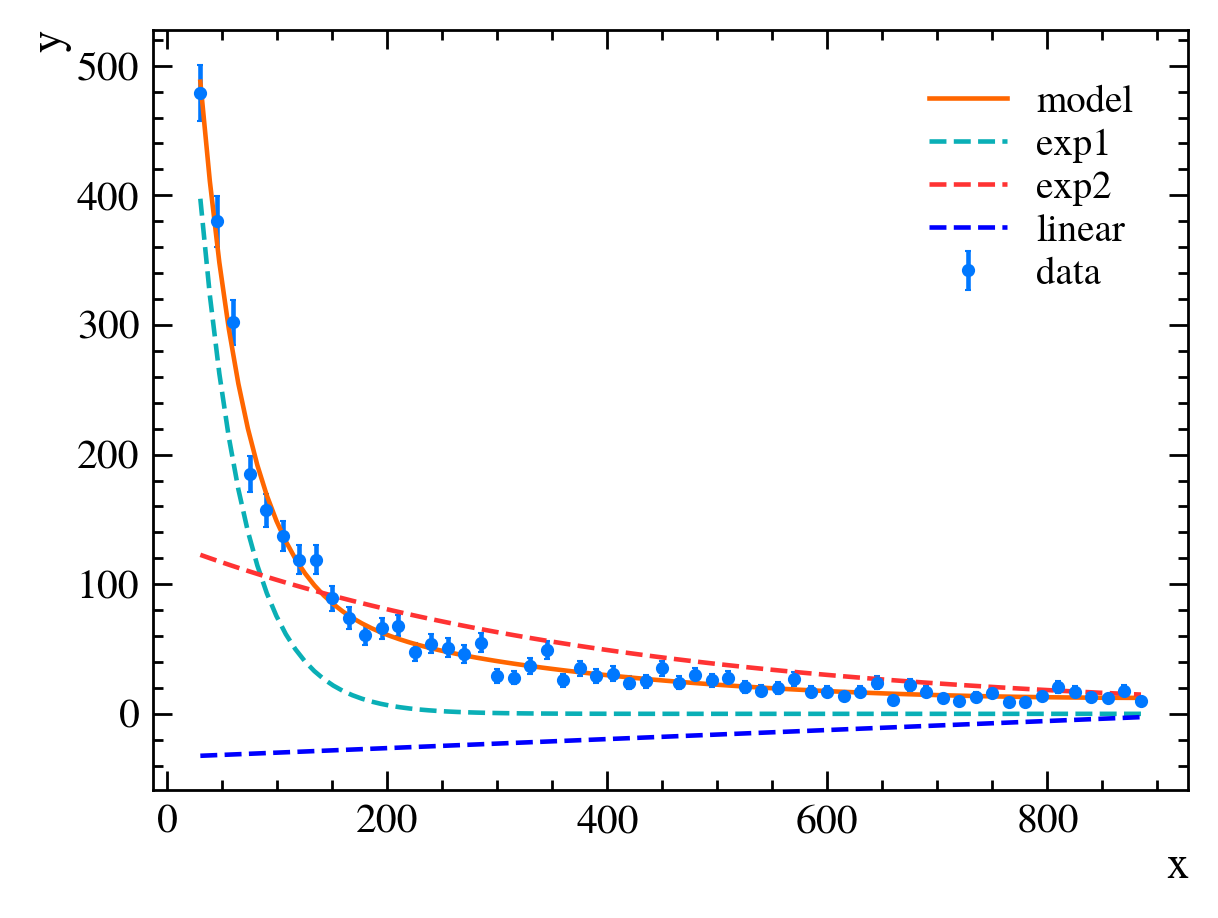

In [16]:
plotmodel(np.array(res.params))

## The better way

In [17]:
params_zfit = [scale_exp1, lamb1, scale_exp2, lamb2, scale_bkg, mlinear]
res = minimizer.minimize(chi2, params=params_zfit)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       13252.81944 Edm =       22512.26254 NCalls =     25
I NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
I MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13198.60471
  Edm           : 22631.20297
  Internal parameters:	[              300    -0.5074375775              300     -0.645504636    -0.6435011088  -0.002000001289]	
  Internal gradient  :	[    -0.1379850382     -160.9645462    0.03543800869      -694.855511      70385.70821      1125822.982]	
  Internal covariance matrix:
[[      912.14374              0              0              0              0              0]
 [              0  0.00060869023              0              0              0              0]
 [              0              0      476.74753              0              0              0]
 [              0              0              0  0.0002078240

In [18]:
print(res)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════════╡
│  False  │    True     │      False       │ 0.003 │                64.74 |  64.73585 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
yield_exp1             819.245       False
lambda1              0.0249416       False
yield_exp2             109.925       False
lambda2             0.00384783       False
yield_bkg              3.86992       False
m                   0.00489673       False


In [19]:
def chi2zfit():
    return chi2([scale_exp1, lamb1, scale_exp2, lamb2, scale_bkg, mlinear])

chi2zfit.errordef = 1

In [20]:
zfit.param.set_values(params_zfit, param_init)  # reset parameters


In [21]:
mlinear.set_value(-0.01)
scale_bkg.set_value(5)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       594.2850539 Edm =       76.80614681 NCalls =      9
I NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
I MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 385.3850674
  Edm           : 16.37771234
  Internal parameters:	[              580    -0.4777081706]	
  Internal gradient  :	[    -0.2482349081      60.20433375]	
  Internal covariance matrix:
[[       1041.008              0]
 [              0  0.00037614089]]]
I MnSeedGenerator Initial state  
  Minimum value : 385.3850674
  Edm           : 16.37771234
  Internal parameters:	[              580    -0.4777081706]	
  Internal gradient  :	[    -0.2482349081      60.20433375]	
  Internal covariance matrix:
[[       1041.008              0]
 [              0  0.00037614089]]]
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 420
I Variable

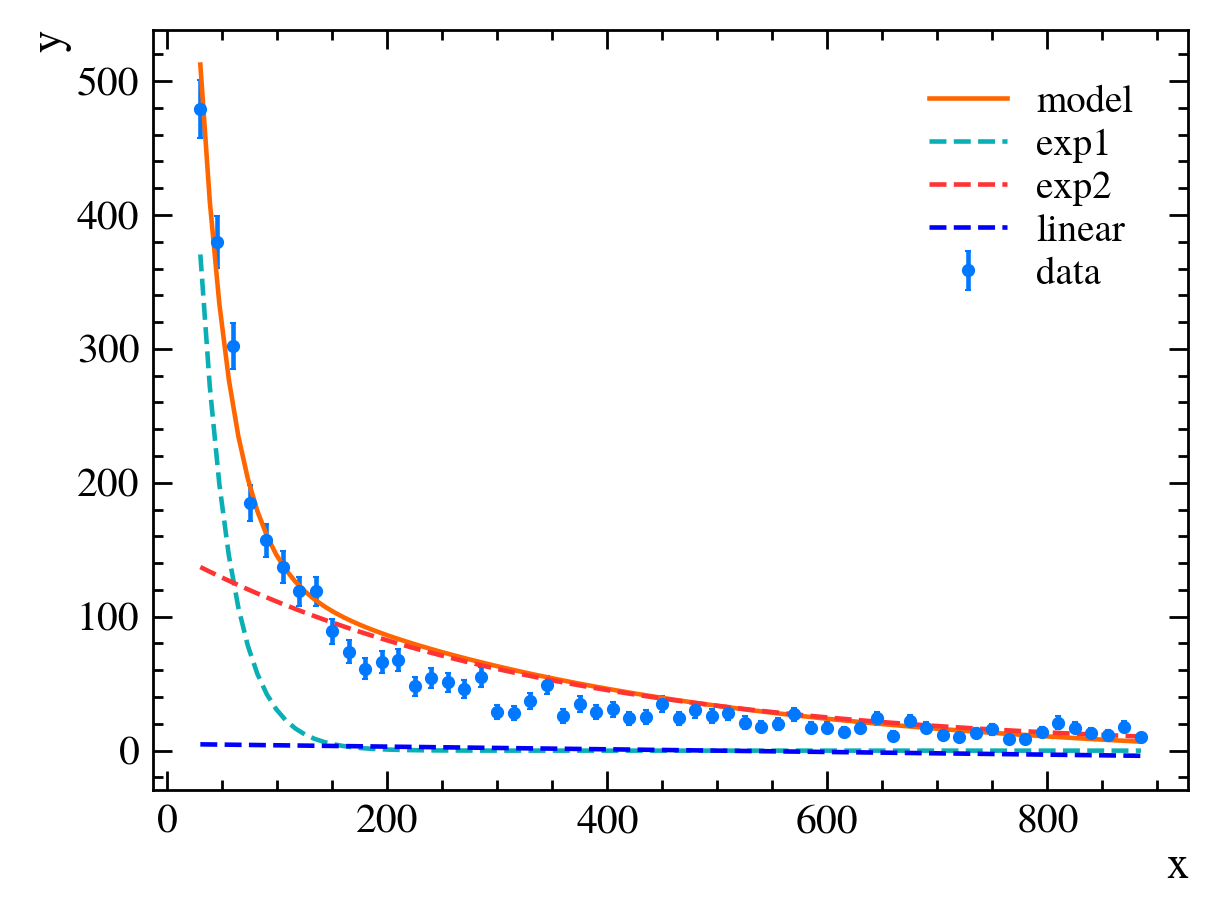

In [22]:
res = minimizer.minimize(chi2zfit, params=params_zfit[:2])
plotmodel(params_zfit)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       342.7966445 Edm =       182.9036351 NCalls =      9
I MnSeedGenerator Initial state  
  Minimum value : 342.7966445
  Edm           : 182.9036351
  Internal parameters:	[      1090.918701              150]	
  Internal gradient  :	[ -1.591116643e-06       10.3154829]	
  Internal covariance matrix:
[[      2334.8583              0]
 [              0      6.8754828]]]
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 420
I VariableMetricBuilder    0 - FCN =       342.7966445 Edm =       182.9036351 NCalls =      9
I VariableMetricBuilder    1 - FCN =       159.8927153 Edm =        14.6439043 NCalls =     14
I VariableMetricBuilder    2 - FCN =       143.9743038 Edm =   1.432683195e-11 NCalls =     20
I VariableMetricBuilder After Hessian
I VariableMetricBuilder    3 - FCN =       143.9743038 Edm =   1.432677705e-11 NCalls =     30
CONVERGED
Finished

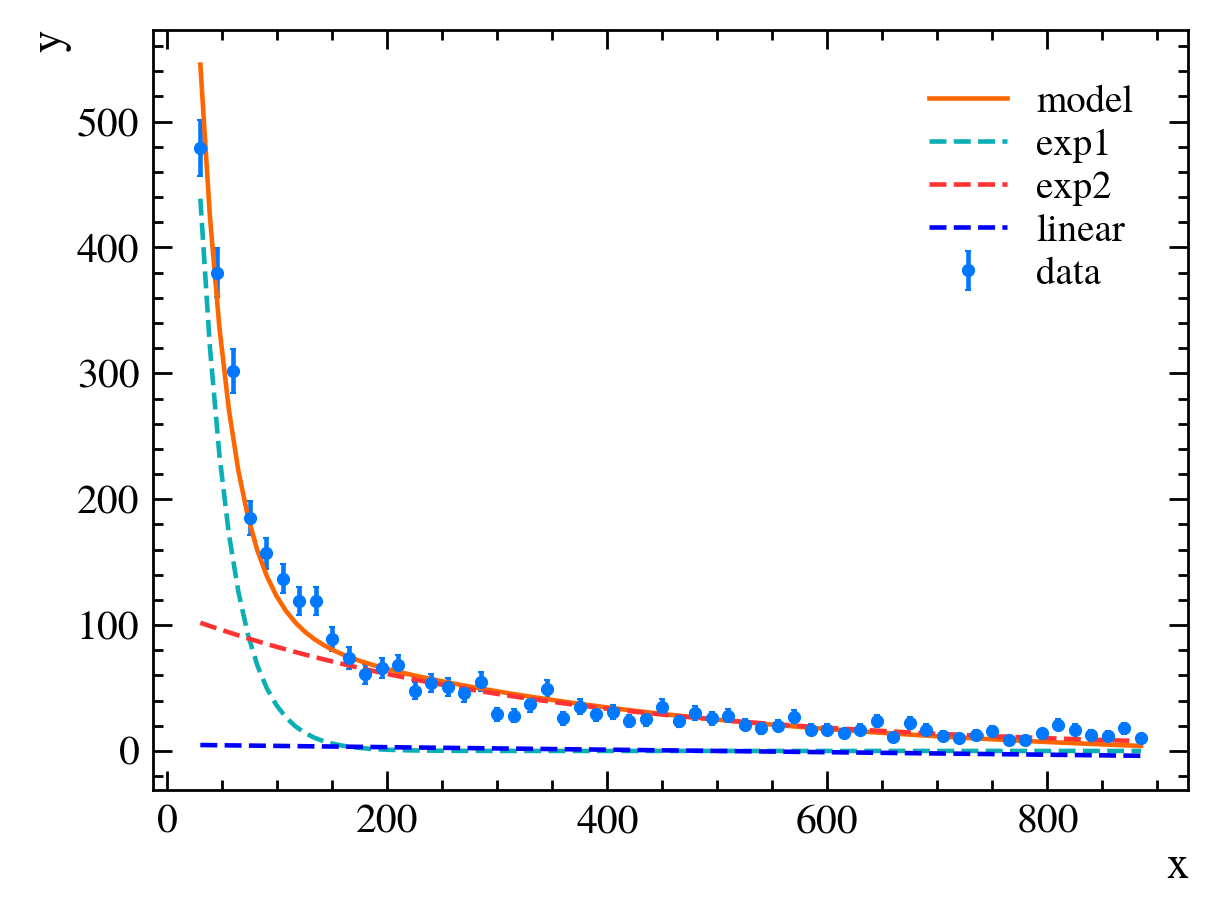

In [23]:
res = minimizer.minimize(chi2zfit, params=[scale_exp1, scale_exp2])
plotmodel(params_zfit)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       143.9743038 Edm =       5.381736135 NCalls =     15
I MnSeedGenerator Initial state  
  Minimum value : 143.9743038
  Edm           : 5.381736135
  Internal parameters:	[      1291.922974    -0.2851698056      111.4516907     -1.228367618]	
  Internal gradient  :	[  1.423359208e-09      227.6015135  -1.66144802e-06      458.7600686]	
  Internal covariance matrix:
[[      2334.8583              0              0              0]
 [              0  0.00035719386              0              0]
 [              0              0      6.8754828              0]
 [              0              0              0  1.4365753e-05]]]
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 680
I VariableMetricBuilder    0 - FCN =       143.9743038 Edm =       5.381736135 NCalls =     15
I VariableMetricBuilder    1 - FCN =       139.3580972 Edm =       6.072515285 NCalls

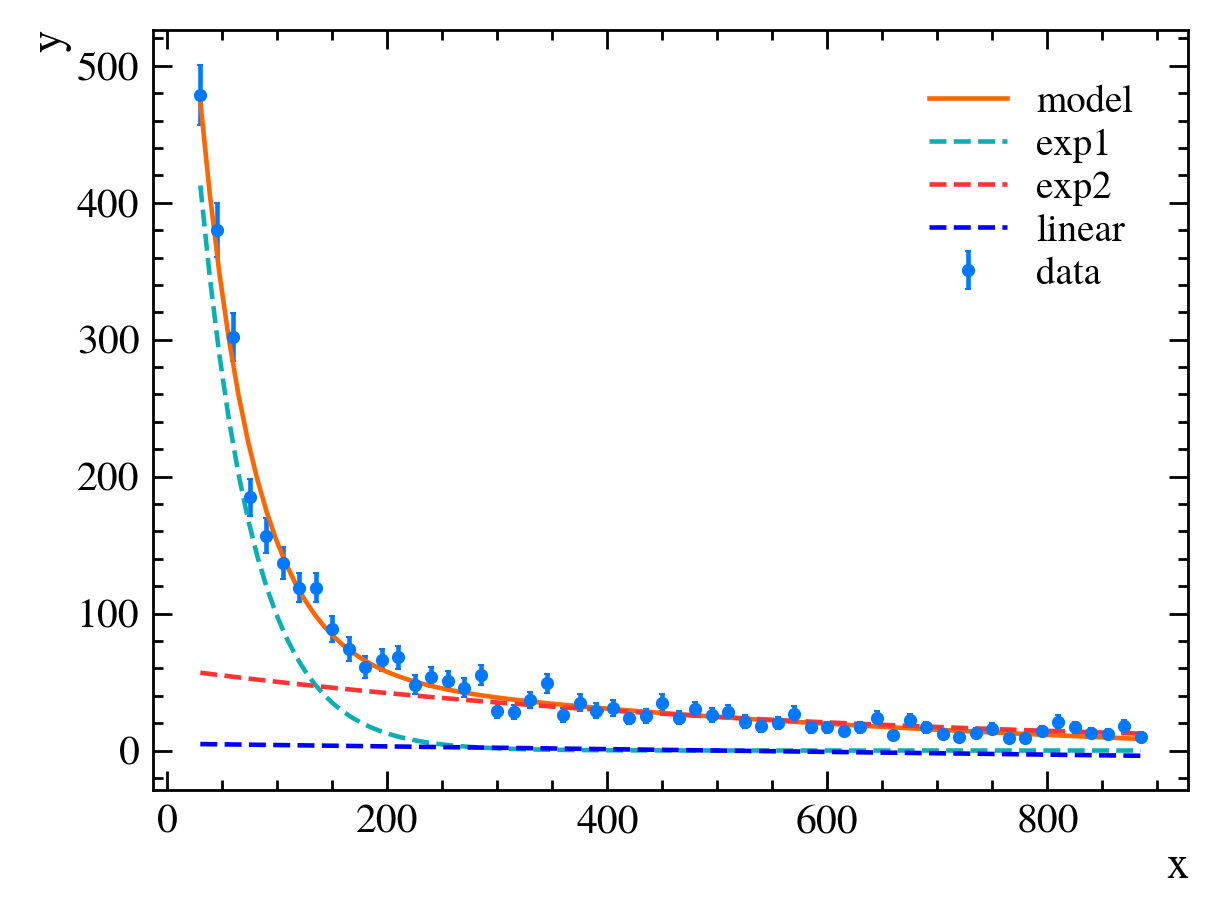

In [24]:
res = minimizer.minimize(chi2zfit, params=[scale_exp1,lamb1, scale_exp2, lamb2])
plotmodel(params_zfit)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       74.21439974 Edm =     0.02395387018 NCalls =     13
I MnSeedGenerator Initial state  
  Minimum value : 74.21439974
  Edm           : 0.02395387018
  Internal parameters:	[      765.5718384       59.9516983     -1.370461484]	
  Internal gradient  :	[  -0.001507704771   -0.02162026621     -23.62451143]	
  Internal covariance matrix:
[[      513.37939              0              0]
 [              0      2.7012126              0]
 [              0              0  0.00016732288]]]
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 545
I VariableMetricBuilder    0 - FCN =       74.21439974 Edm =     0.02395387018 NCalls =     13
I VariableMetricBuilder    1 - FCN =       74.19537627 Edm =     0.01350078768 NCalls =     21
I VariableMetricBuilder    2 - FCN =       74.10272456 Edm =     0.02861876705 NCalls =     30
I VariableMetricBuilder    3 - FCN =

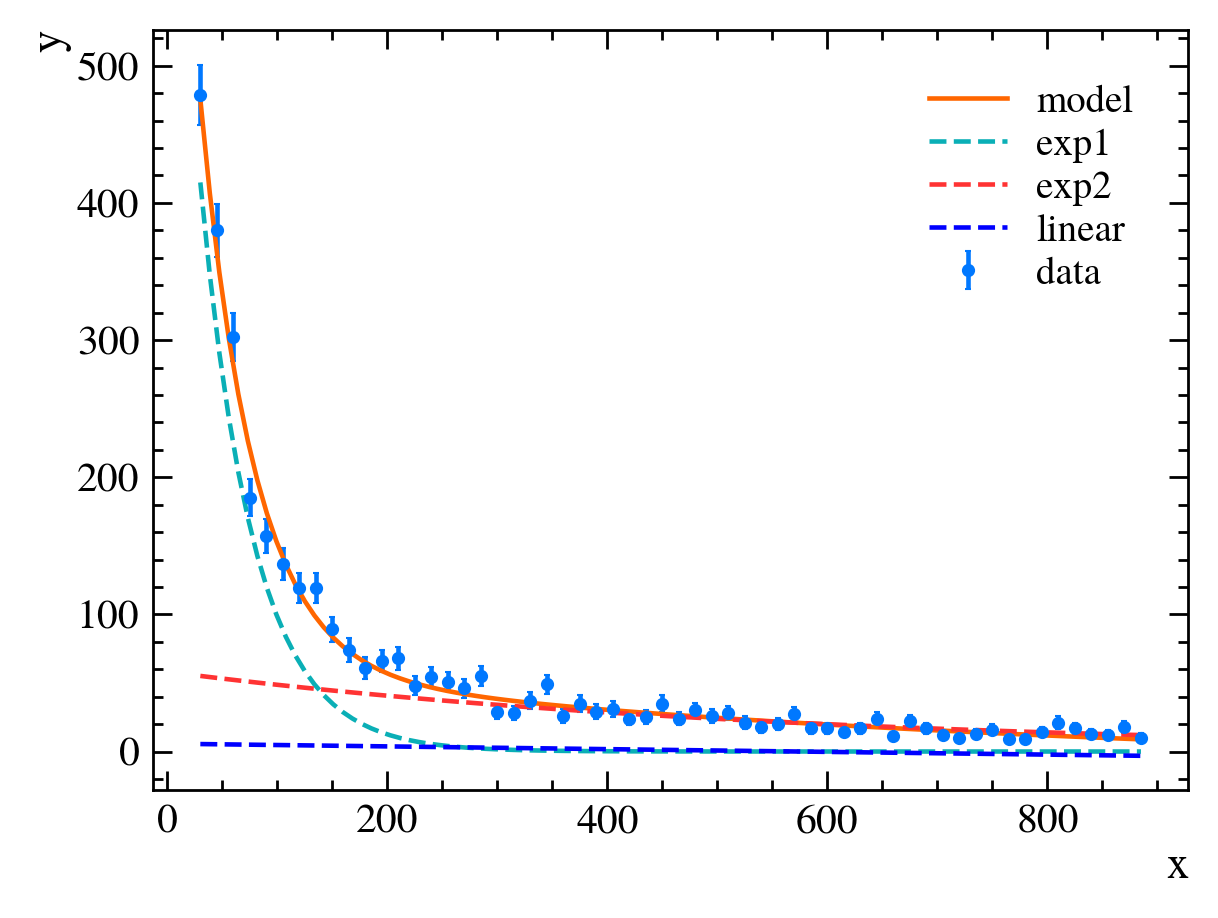

In [25]:
res = minimizer.minimize(chi2zfit, params=[scale_exp1,scale_exp2, scale_bkg])
plotmodel(params_zfit)

I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       74.05604081 Edm =     0.04705556911 NCalls =     21
I MnSeedGenerator Initial state  
  Minimum value : 74.05604081
  Edm           : 0.04705556911
  Internal parameters:	[      769.9058838     -0.630437701      58.15143967     -1.310301846     -1.356283608  -0.002000001333]	
  Internal gradient  :	[  0.0001795946546       16.5378266   0.002432785544     -68.28830904    0.08205384041     -1271.722079]	
  Internal covariance matrix:
[[      513.37939              0              0              0              0              0]
 [              0  0.00011417356              0              0              0              0]
 [              0              0      2.7012126              0              0              0]
 [              0              0              0  1.9864243e-05              0              0]
 [              0              0              0              0  0.000144809

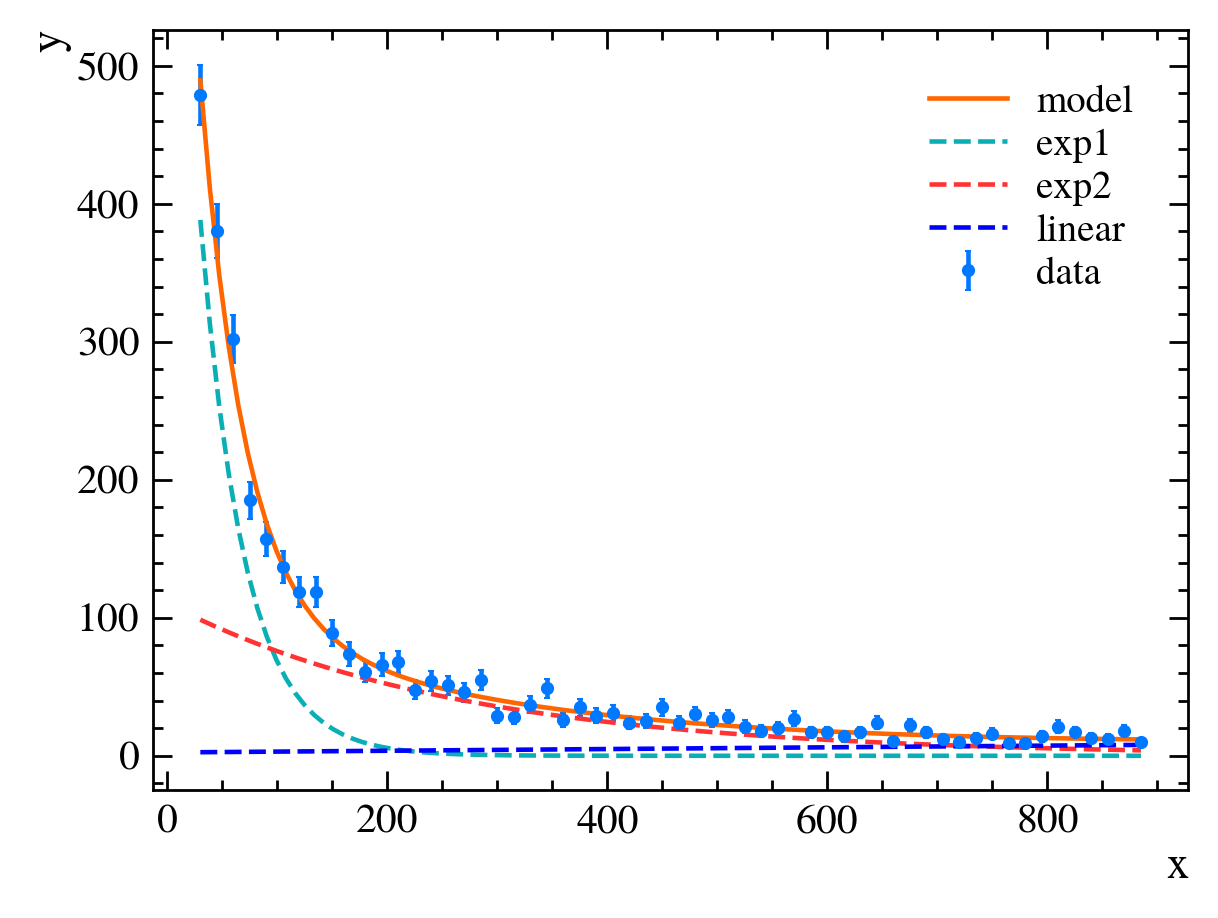

In [26]:
res = minimizer.minimize(chi2zfit, params=params_zfit)
plotmodel(params_zfit)

In [27]:
print(res)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.0008 │                64.72 |  64.72066 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
yield_exp1             819.041       False
lambda1              0.0248785       False
yield_exp2             110.385       False
lambda2             0.00376005       False
yield_bkg              2.40729       False
m                   0.00621457       False


In [28]:
res.hesse()
res.errors()
print(res)

/usr/local/lib/python3.10/dist-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")
/usr/local/lib/python3.10/dist-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')

W MnMinos UP value has changed, need to update FunctionMinimum class
I MnMinos Determination of upper Minos error for parameter 0
I MnFunctionCross Run Migrad with fixed parameters:
  Pos 0: yield_exp1 = 888.435
I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =       65.59881191 Edm =    0.002226894969 NCalls =     21
I MnSeedGenerator Initial state  
  Minimum value : 65.59881191
  Edm           : 0.002226894969
  Internal parameters:	[    -0.4855363324      117.4494496     -1.176853895     -1.432553006   0.001346496915]	
  Internal gradient  :	[      4.558427188   -0.02000390169      6.119088916    -0.7074582389      26.63509654]	
  Internal covariance matrix:
[[   0.0013333345     0.58071296    0.001236878   0.0028885771 -4.9995315e-06]
 [     0.58071296      369.21986     0.46644772    -0.90091901    0.014130118]
 [    0.001236878     0.46644772   0.0020429524   0.0098817094 -4.6671022e-05]
 [   0.0028885771    -0.90091901   

In [29]:
res.covariance()

array([[ 4.81553352e+03,  1.27573693e-01,  4.90262964e+02,
         1.13941610e-02, -1.54323034e+00,  3.59403409e-02],
       [ 1.27573693e-01,  5.86156460e-06,  3.80423436e-02,
         1.30339490e-06,  4.27236648e-03, -1.26360481e-07],
       [ 4.90262964e+02,  3.80423436e-02,  4.19132875e+02,
         9.91438571e-03, -3.13378765e+01,  7.43095727e-02],
       [ 1.13941610e-02,  1.30339490e-06,  9.91438571e-03,
         7.46576795e-07,  6.41515914e-03, -4.29460142e-06],
       [-1.54323034e+00,  4.27236648e-03, -3.13378765e+01,
         6.41515914e-03,  1.07881831e+02, -9.82355058e-02],
       [ 3.59403409e-02, -1.26360481e-07,  7.43095727e-02,
        -4.29460142e-06, -9.82355058e-02,  9.75700122e-05]])

In [30]:
fmin = res.fmin
ndof = y.shape[0] - len(params_zfit)  # number of fitting points minus number of parameters
chi2ndof = fmin / ndof

In [31]:
chi2ndof

1.2446280374038363

In [32]:
1 - sp.stats.chi2.cdf(fmin, ndof)  # p-value (where are we in the tail of all possible distributions?)

0.11080187345629466

p value: can we reject H0 (i.e. can we say that this fits badly)?

OR: we have assumptions in there! Are they valid? (most likely yes, here. But low stats or more complicated function can make it difficult)